# Отток клиентов

**Цель работы:** \
Банк начал терять клиентов. Сохранять текущих клиентов дешевле, чем привлекать новых.
Необходимо построить модель прогноза оттока клиентов с предельно большим значением F1-меры (не менее 0.59).\
Также требуется измерить AUC-ROC, сопоставив её значение с F1-мерой.

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

Признаки:
- `RowNumber` — индекс строки в данных;
- `CustomerId` — уникальный идентификатор клиента;
- `Surname` — фамилия;
- `CreditScore` — кредитный рейтинг;
- `Geography` — страна проживания;
- `Gender` — пол;
- `Age` — возраст;
- `Tenure` — сколько лет человек является клиентом банка;
- `Balance` — баланс на счёте;
- `NumOfProducts` — количество продуктов банка, используемых клиентом;
- `HasCrCard` — наличие кредитной карты;
- `IsActiveMember` — активность клиента;
- `EstimatedSalary` — предполагаемая зарплата.

Целевой признак:
- `Exited` — факт ухода клиента.


**Ход работы:**
1) исследование исходных данных;\
2) предобработка данных;\
3) определение дисбаланса;\
4) подбор алгоритма;\
5) подбор гипермараметров;\
6) тестирование

## Исследование и подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, roc_curve, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# считывание датасета с учётом возможных вариантов его расположения
try:
    data = pd.read_csv('../../07 обучение с учителем/проект Отток клиентов/Churn.csv')
except:
    try:
        data = pd.read_csv('/datasets/Churn.csv')
    except:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [3]:
data.head() # первые 5 признаков

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [4]:
data.info() # общее описание датасета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.query('Tenure.isna()').head() # первые 5 позиций с пропусками в 'Tenure'

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
30         31    15589475    Azikiwe          591     Spain  Female   39   
48         49    15766205        Yin          550   Germany    Male   38   
51         52    15768193  Trevisani          585   Germany    Male   36   
53         54    15702298   Parkhill          655   Germany    Male   41   
60         61    15651280     Hunter          742   Germany    Male   35   

    Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
30     NaN       0.00              3          1               0   
48     NaN  103391.38              1          0               1   
51     NaN  146050.97              2          0               0   
53     NaN  125561.97              1          0               0   
60     NaN  136857.00              1          0               0   

    EstimatedSalary  Exited  
30        140469.38       1  
48         90878.13       0  
51         86424.57       0  
53        164040.94       1  
60         84509.57       0

909 пропусков (9%) в "Tenure". С первого взгляда причина неясна.

Варианты действий с пропуском в 'Tenure':
* ничего не делаем, оставляем NaN (не получилось; LogisticRegression ниже выдала ошибку из-за пропусков);
* удаляем объекты с пропусками (не нравится этот вариант из-за потери 9% данных; меньше данных - хуже качество модели);
* попробовать найти связь/закономерность пропусков (ниже); 
* заменяем медианой (стратифицированной по целевому признаку) (выбираем этот вариант);
* заполнить пропуски через модель ML (хороший вариант, но более трудозатратный, чем заполнение медианами).

### Проверка дубликатов

In [6]:
data['Surname'].apply(lambda x: bool(re.search('^\s|\s$',x))).sum()  # число пробелов по краям строки в 'Surname'

0

In [7]:
data.duplicated().sum()                                              # наличие задублированных объектов

0

In [8]:
data['RowNumber'].duplicated().sum()                                 # наличие задублированных 'RowNumber'

0

In [9]:
data['CustomerId'].duplicated().sum()                                # наличие задублированных 'CustomerId'

0

In [10]:
data['Geography'].value_counts()                                     # уникальные 'Geography'

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [11]:
data['Gender'].value_counts()                                        # уникальные 'Gender'

Male      5457
Female    4543
Name: Gender, dtype: int64

In [12]:
data.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)  # удаляем бесполезные для ML столбцы

### OrdinalEncoder

In [13]:
# порядково кодируем 2 категориальных признака; 
# помимо ML это поможет проанализировать взаимосвязь закодированных признаков с осталными
encoder = OrdinalEncoder()
data_ordinal = data.drop(['Geography','Gender'],axis=1).join(
    pd.DataFrame(encoder.fit_transform(data[['Geography','Gender']]),columns=['Geography','Gender']))

In [14]:
data_ordinal['Geography'].value_counts() # уникальные 'Geography' после кодировки (сопоставим обозначение)

0.0    5014
1.0    2509
2.0    2477
Name: Geography, dtype: int64

0.0 ~ France\
1.0 ~ Germany\
2.0 ~ Spain

In [15]:
data_ordinal['Gender'].value_counts() # уникальные 'Gender' после кодировки (сопоставим обозначение)

1.0    5457
0.0    4543
Name: Gender, dtype: int64

1.0 ~ Male\
0.0 ~ Femail

### Связь пропусков с другими признаками

In [16]:
# посмотрим есть ли корреляция между пропусками в 'Tenure' и другими признаками
# присвоим - 0 пропуску, всем остальные ячейки исправим на 1
data_ordinal.loc[data_ordinal['Tenure'].isna(),'Tenure_indicator'] = 0
data_ordinal.loc[~data_ordinal['Tenure'].isna(),'Tenure_indicator'] = 1
data_ordinal.drop(['Tenure','Tenure_indicator'],axis=1).corrwith(data_ordinal['Tenure_indicator']).round(2)

CreditScore        0.01
Age                0.01
Balance            0.00
NumOfProducts     -0.00
HasCrCard         -0.00
IsActiveMember     0.00
EstimatedSalary    0.01
Exited             0.00
Geography          0.00
Gender             0.01
dtype: float64

In [17]:
# связь пропусков 'Tenure' с другими признаками отсутствует; уберём лишний вспомогательный столбец
data_ordinal.drop('Tenure_indicator',axis=1,inplace=True)

### describe

In [18]:
# описание признаков с разбивкой по целевому признаку 'Exited'
describe =\
data_ordinal.query('Exited==0').drop(['Geography'],axis=1).describe().join(
data_ordinal.query('Exited==1').drop(['Geography'],axis=1).describe(),
    lsuffix='_0',rsuffix='_1').reindex(columns=['CreditScore_0','CreditScore_1','Age_0','Age_1','Tenure_0','Tenure_1',
                                                'Balance_0','Balance_1','NumOfProducts_0','NumOfProducts_1','HasCrCard_0',
                                                'HasCrCard_1','IsActiveMember_0','IsActiveMember_1','EstimatedSalary_0',
                                                'EstimatedSalary_1','Exited_0','Exited_1','Gender_0','Gender_1'])
describe.round(1)

CreditScore_0  CreditScore_1   Age_0   Age_1  Tenure_0  Tenure_1  \
count         7963.0         2037.0  7963.0  2037.0    7237.0    1854.0   
mean           651.9          645.4    37.4    44.8       5.0       4.9   
std             95.7          100.3    10.1     9.8       2.9       2.9   
min            405.0          350.0    18.0    18.0       0.0       0.0   
25%            585.0          578.0    31.0    38.0       3.0       2.0   
50%            653.0          646.0    36.0    45.0       5.0       5.0   
75%            718.0          716.0    41.0    51.0       7.0       7.0   
max            850.0          850.0    92.0    84.0      10.0      10.0   

       Balance_0  Balance_1  NumOfProducts_0  NumOfProducts_1  HasCrCard_0  \
count     7963.0     2037.0           7963.0           2037.0       7963.0   
mean     72745.3    91108.5              1.5              1.5          0.7   
std      62848.0    58360.8              0.5              0.8          0.5   
min          0.0        0.0              1.0              1.0          0.0   
25%          0.0    38340.0              1.0              1.0          0.0   
50%      92072.7   109349.3              2.0              1.0          1.0   
75%     126410.3   131433.3              2.0              2.0          1.0   
max     221532.8   250898.1              3.0              4.0          1.0   

       HasCrCard_1  IsActiveMember_0  IsActiveMember_1  EstimatedSalary_0  \
count       2037.0            7963.0            2037.0             7963.0   
mean           0.7               0.6               0.4            99738.4   
std            0.5               0.5               0.5            57405.6   
min            0.0               0.0               0.0               90.1   
25%            0.0               0.0               0.0            50783.5   
50%            1.0               1.0               0.0            99645.0   
75%            1.0               1.0               1.0           148610.0   
max            1.0               1.0               1.0           199992.5   

       EstimatedSalary_1  Exited_0  Exited_1  Gender_0  Gender_1  
count             2037.0    7963.0    2037.0    7963.0    2037.0  
mean            101465.7       0.0       1.0       0.6       0.4  
std              57912.4       0.0       0.0       0.5       0.5  
min                 11.6       0.0       1.0       0.0       0.0  
25%              51907.7       0.0       1.0       0.0       0.0  
50%             102460.8       0.0       1.0       1.0       0.0  
75%             152422.9       0.0       1.0       1.0       1.0  
max             199808.1       0.0       1.0       1.0       1.0

In [19]:
# во сколько раз статистика (mean и median) у покинувших банк больше статистики оставшихся
describe_ratio = pd.DataFrame()
for j in range (0,describe.shape[1]-1,2):
    describe_ratio = describe_ratio.join(pd.DataFrame(describe.iloc[[1,5],j+1]/describe.iloc[[1,5],j],
                                                      columns=[describe.columns[j][:-2]]),how='right')
describe_ratio.drop('Exited',axis=1).round(1)

CreditScore  Age  Tenure  Balance  NumOfProducts  HasCrCard  \
mean          1.0  1.2     1.0      1.3            1.0        1.0   
50%           1.0  1.2     1.0      1.2            0.5        1.0   

      IsActiveMember  EstimatedSalary  Gender  
mean             0.7              1.0     0.8  
50%              0.0              1.0     0.0

Вывод: 
* возраст покинувших банк на 20% выше;
* баланс покинувших банк на 20-30% выше; разница в статистиках баланса получается за счёт большого количества нулевых счетов у оставшихся клиентов; если убрать нулевые значения средние балансов будут примерно равны у оставшихся и ушедших (видно из графической аналитики ниже);
* покинувшие банк использовали меньшее число продуктов и были менее активны; в тоже время пользование 3-мя или 4-мя продуктами в небольших количествах было в основном у покинувших банк (видно ниже на диаграммах kde и столбчатой);
* среди покинувших банк больше женщин (60%); среди оставшихся больше мужчин (60%); общее количество мужчин (55%);
* кредитный рейтинг, срок пользования банком, наличие кредитной карты и зарплата не влияют на решение оставить банк;
* ошибочных выбросов в данных нет; все числа логичны и соответствуют возможным значениям признаков.

### Взаимосвязь признаков

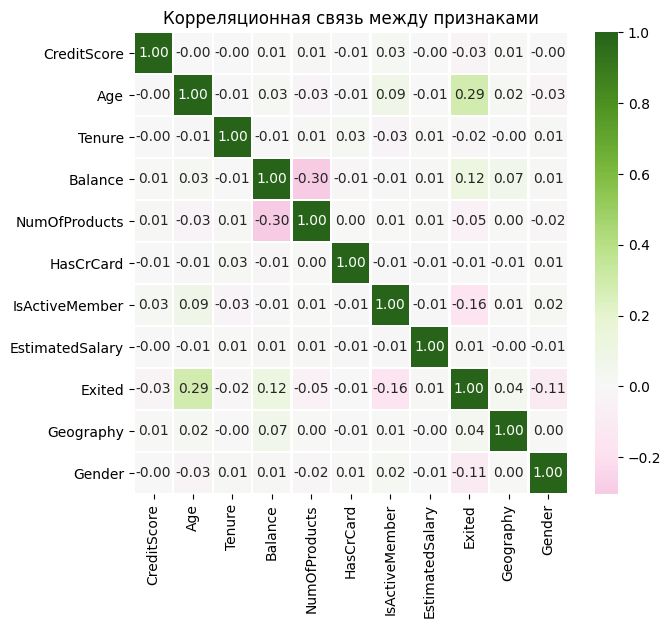

In [20]:
plt.figure(figsize=(7,6))
sns.heatmap(data_ordinal.corr(),annot=True,fmt='.2f',center= 0,cmap='PiYG',linewidth=1)
plt.title('Корреляционная связь между признаками'); plt.show()

* Слабая отрицательная связь между NumOfProducts и Balance. Более состоятельные клиенты предпочитают не распыляться по разным продуктам и делают ставку на небольшое количество видов услуг.
* Слабая положительная связь Exited и Age. Более возрастные клиенты чаще принимают решение покинуть банк.
* Очень слабая положительная связь Exited и Balance. Связано с бОльшим количеством нулевых счетов у оставшихся.
* Очень слабая отрицательная связь Exited и Gender. Женщины чаще покидают банк.
* Очень слабая отрицательная связь Exited и IsActiveMember. Менее активные клиенты чаще покидают банк.

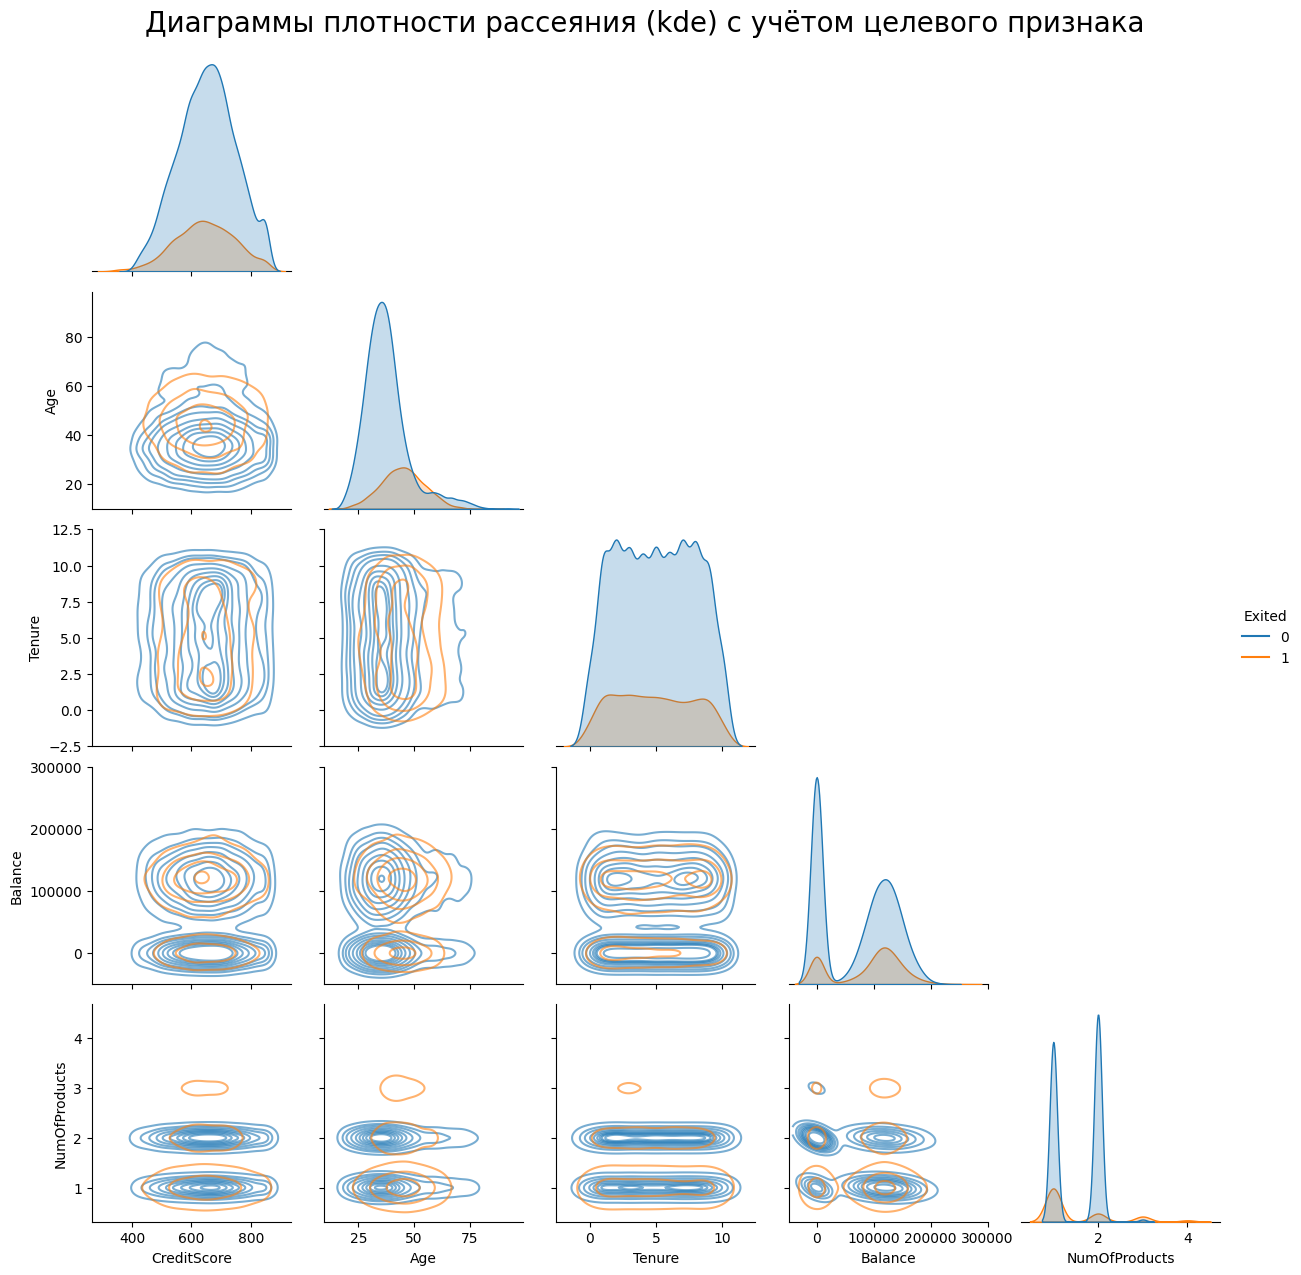

In [21]:
# Wall time: 46.4 s
ax=sns.pairplot(data_ordinal[['CreditScore','Age','Tenure','Balance','NumOfProducts','Exited']],corner=True,hue='Exited',
                plot_kws=dict(alpha=0.6),kind="kde")
ax.fig.suptitle('Диаграммы плотности рассеяния (kde) с учётом целевого признака',y=1.02,fontsize= 20); plt.show()

Вывод:
* явно видны смещения в большую сторону "пиков" плотности возраста ушедших относительно оставшихся (в том числе на гистограмме);
* у диаграмм баланса 2 пика (один на 0); разберём этот кейс более подробно ниже;
* количество используемых продуктов у оставшихся в основном 1 или 2, у ушедших - 1; тем не менее ушедшие чаще пользуются 3 и 4 продуктами (см. ниже столбчатую диаграмму);


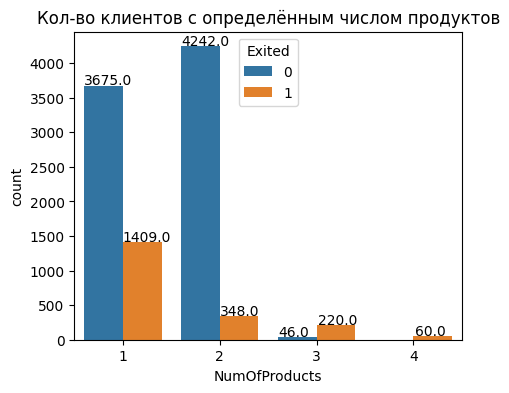

In [22]:
plt.figure(figsize=(5,4))
ax=sns.countplot(data=data_ordinal,x='NumOfProducts',hue='Exited')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Кол-во клиентов с определённым числом продуктов'); plt.show()

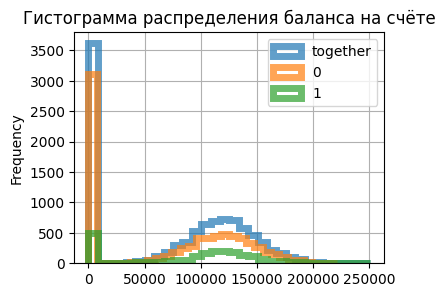

In [23]:
ax=data_ordinal.plot(y='Balance',kind='hist',bins=30,grid=True,histtype='step',linewidth=5,alpha=0.7, label='together',
                    title='Гистограмма распределения баланса на счёте',figsize=(4,3))
data_ordinal[data_ordinal['Exited']==0].plot(y='Balance',kind='hist',bins=30,grid=True,histtype='step',linewidth=5,ax=ax,
                                            alpha=0.7, label='0')
data_ordinal[data_ordinal['Exited']==1].plot(y='Balance',kind='hist',bins=30,grid=True,histtype='step',linewidth=5,ax=ax,
                                            alpha=0.7, label='1')
plt.show()

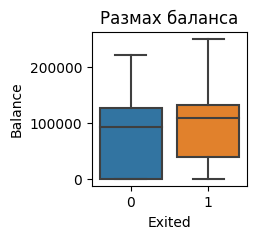

In [24]:
plt.figure(figsize=(2,2))
sns.boxplot(data=data_ordinal,y='Balance',x='Exited')
plt.title('Размах баланса'); plt.show()

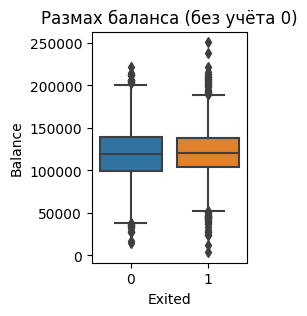

In [25]:
plt.figure(figsize=(2,3))
sns.boxplot(data=data_ordinal.query('Balance>0'),y='Balance',x='Exited')
plt.title('Размах баланса (без учёта 0)'); plt.show()

In [26]:
# доля клиентов с балансом = 0
data_ordinal['Balance'][data_ordinal['Balance']==0].count()/data_ordinal['Balance'].count().round(2)

0.3617

In [27]:
# доля оставшихся клиентов с балансом = 0
data_ordinal[(data_ordinal['Balance']==0)&(data_ordinal['Exited']==0)].shape[0]/data_ordinal[data_ordinal['Exited']==0].shape[0]

0.39143538867261085

In [28]:
# доля ушедших клиенотв с балансом = 0
data_ordinal[(data_ordinal['Balance']==0)&(data_ordinal['Exited']==1)].shape[0]/data_ordinal[data_ordinal['Exited']==1].shape[0]

0.24545900834560627

Нулевой баланс значительно отражается на среднем значении. Доля оставшихся клиентов с нулевым балансом на 15% выше доли ушедших клиентов с нулевым балансом.

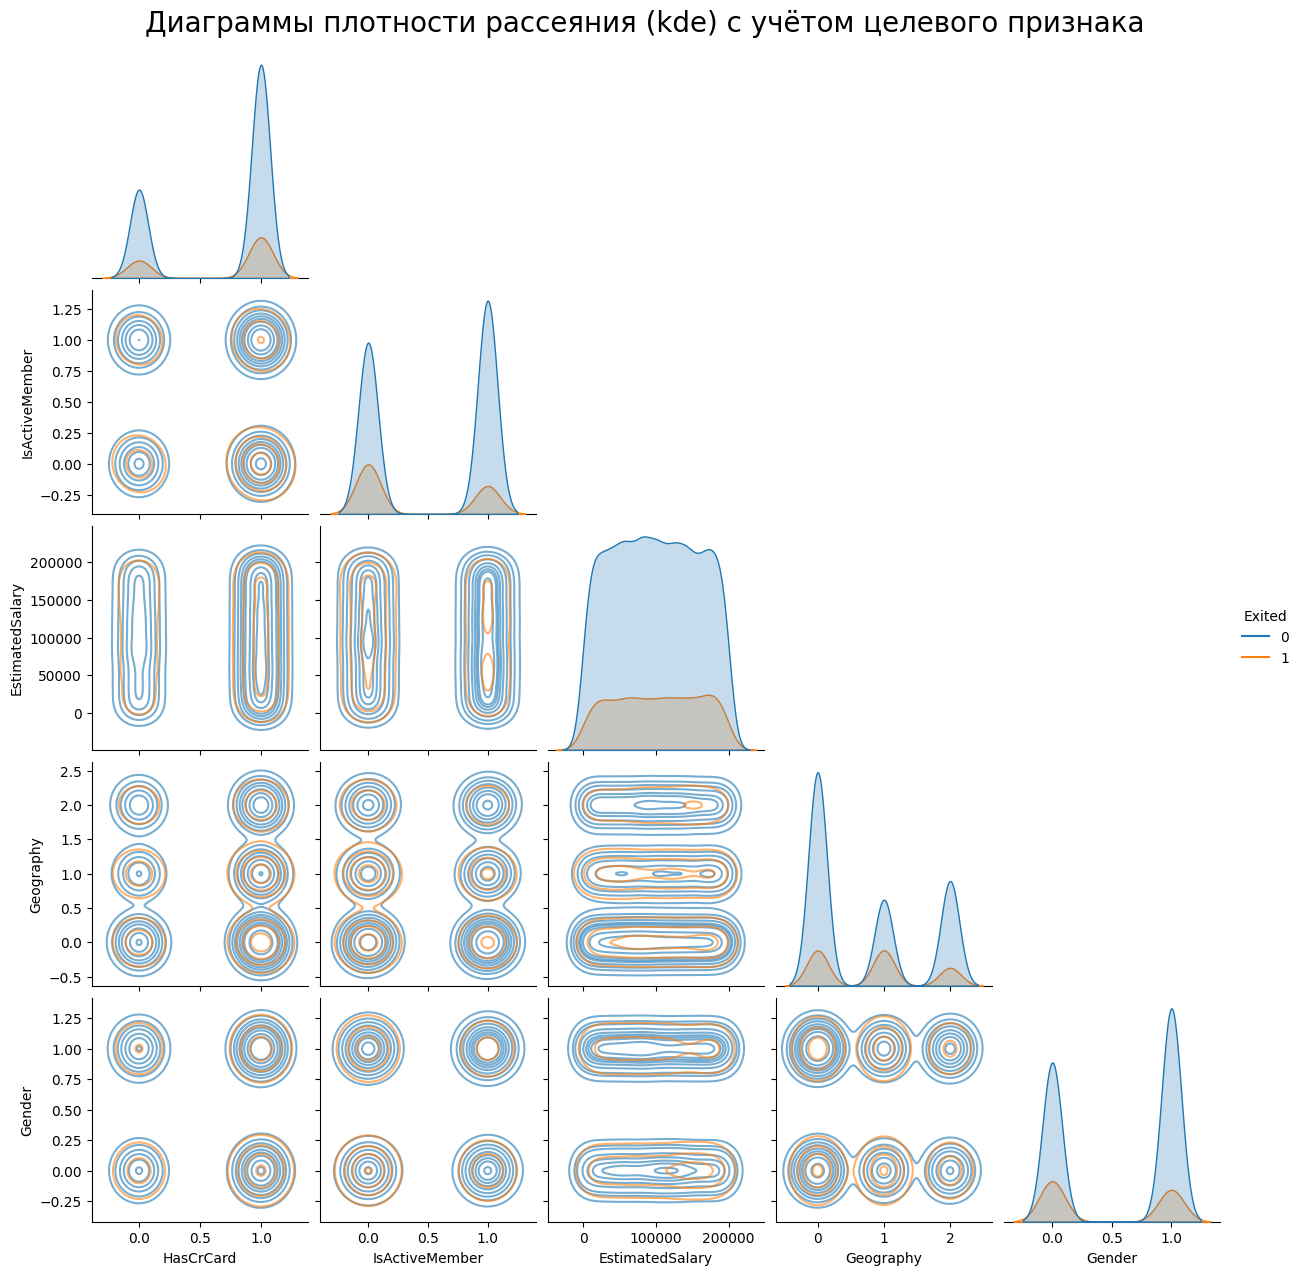

In [29]:
# Wall time: 48 s
ax=sns.pairplot(data_ordinal[['HasCrCard','IsActiveMember','EstimatedSalary','Geography','Gender','Exited']],corner=True,
                hue='Exited',plot_kws=dict(alpha=0.6),kind="kde")
ax.fig.suptitle('Диаграммы плотности рассеяния (kde) с учётом целевого признака',y=1.02,fontsize= 20); plt.show()

Вывод:
* закономерностей и аномалий не выявлено; практически все максимумы оставшихся/уехавших соосны;
* совсем немного наблюдается бОльшая зарплата у покинувших банк женщин, чем у оставшихся женщин;
* очень незначительно зарплата в Испании у покинувших выше зарплаты оставшихся.

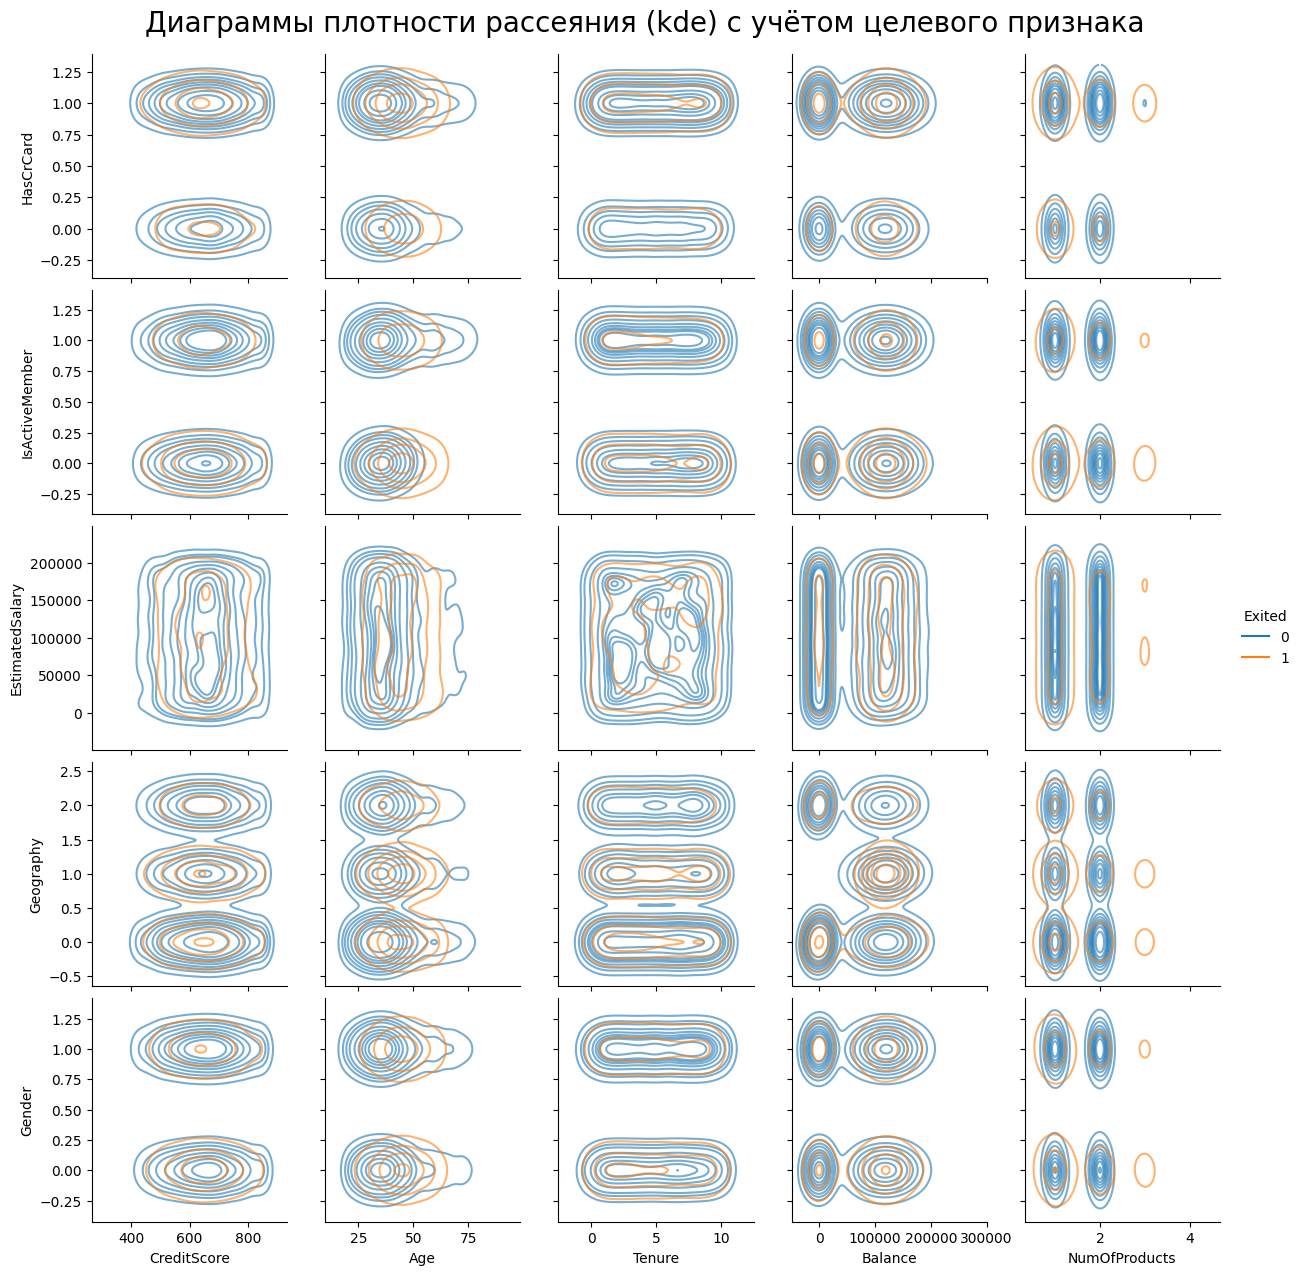

In [30]:
# Wall time: 1min 54s
ax=sns.pairplot(data_ordinal,x_vars=['CreditScore','Age','Tenure','Balance','NumOfProducts'],
                y_vars=['HasCrCard','IsActiveMember','EstimatedSalary','Geography','Gender'],hue='Exited',
                plot_kws=dict(alpha=0.6),kind="kde")
ax.fig.suptitle('Диаграммы плотности рассеяния (kde) с учётом целевого признака',y=1.02,fontsize= 20); plt.show()

Вывод:
* нулевого баланса нет у клиентов в Германии;
* в остальном идентичные предыдущим диаграммам наблюдения по возрасту, балансу, числу используемых продуктов.

### One-Hote Encoding

In [31]:
# кодируем по OHE
data_ohe = pd.get_dummies(data)
data_ohe.head(3)

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42     2.0       0.00              1          1   
1          608   41     1.0   83807.86              1          0   
2          502   42     8.0  159660.80              3          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_France  \
0               1        101348.88       1                 1   
1               1        112542.58       0                 0   
2               0        113931.57       1                 1   

   Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  
0                  0                0              1            0  
1                  0                1              1            0  
2                  0                0              1            0

### Заполнение пропусков

Пропуски заполняем в конце первого раздела чтобы ранее в процессе анализа мы могли получить исходные статистики и визуализацию (без корректировки за счёт предполагаемых значений в пропусках).\
Пропуски заполняем непосредственно перед разделом, связанным с ML, так как алгоритму ML необходимы данные без пропусков.

In [32]:
# заполним пропуски "Tenure" в data_ohe медианным значением с учётом стратификации классов
data_ohe.loc[(data_ohe['Tenure'].isna()) & (data_ohe['Exited']==0),'Tenure'] = data_ohe.loc[
    data_ohe['Exited']==0,'Tenure'].median()
data_ohe.loc[(data_ohe['Tenure'].isna()) & (data_ohe['Exited']==1),'Tenure'] = data_ohe.loc[
    data_ohe['Exited']==1,'Tenure'].median()

In [33]:
# заполним пропуски "Tenure" в data_ordinal медианным значением с учётом стратификации классов
data_ordinal.loc[(data_ordinal['Tenure'].isna()) & (data_ordinal['Exited']==0),'Tenure'] = data_ordinal.loc[
    data_ordinal['Exited']==0,'Tenure'].median()
data_ordinal.loc[(data_ordinal['Tenure'].isna()) & (data_ordinal['Exited']==1),'Tenure'] = data_ordinal.loc[
    data_ordinal['Exited']==1,'Tenure'].median()

### Вывод:

* датафрейм 10000 х 14;  в признаке "Tenure" 909 пропусков (9%), причина неясна, связь наличия пропусков с другими признаками отсутствует; для ML пропуски заполнены медианным значением с учётом классовой стратификации; дубликатов нет;
* возраст покинувших банк на 20% выше; слабая положительная связь "Exited" и "Age";
* баланс покинувших банк на 20-30% выше; разница получается за счёт большого количества нулевых счетов у оставшихся клиентов; если убрать нулевые значения средние балансов будут примерно равны у оставшихся и ушедших; нулевых балансов нет у клиентов в Германии;
* покинувшие банк использовали меньшее число продуктов и были менее активны; в то же время пользование 3-мя или 4-мя продуктами в небольших количествах было, в основном, у покинувших;
* слабая отрицательная связь между NumOfProducts и Balance; более состоятельные клиенты предпочитают не распыляться по разным продуктам и делают ставку на небольшое количество видов услуг.
* среди покинувших банк больше женщин (60%); среди оставшихся больше мужчин (60%); общее количество мужчин (55%);
* кредитный рейтинг, срок пользования банком, наличие кредитной карты и зарплата не влияют на решение оставить банк; 
* ошибочных выбросов в данных нет;
* данные закодированы двумя методами (OE, OHE). Для последующего ML будем использовать только OHE для унификации экспериментов с разными моделями.

## Исследование задачи

### Проверка дисбаланса классов

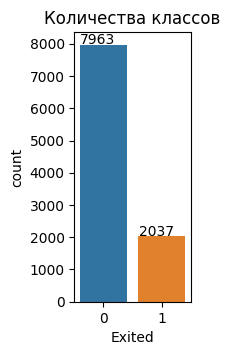

In [34]:
plt.figure(figsize=(1.5,3.5))
ax = sns.countplot(data=data,x='Exited')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Количества классов'); plt.show()

Дисбалан, примерно, 1/4. Является значительным и может отразится на качестве предсказания модели. Для сравнения проверим качество без балансировки.

### Разделение данных

In [35]:
# разбиваем OHE-данные на признаки и целевой признак
target_ohe   = data_ohe['Exited']
features_ohe = data_ohe.drop('Exited',axis=1)

In [36]:
# разбиваем OHE-данные на обучающую, валидационную и тестовую выборки (60:20:20)
features_ohe_train,features_ohe_valid_test,target_ohe_train,target_ohe_valid_test = train_test_split(
    features_ohe,target_ohe,test_size=0.4,random_state=12345,stratify=target_ohe)
features_ohe_valid,features_ohe_test,target_ohe_valid,target_ohe_test = train_test_split(
    features_ohe_valid_test,target_ohe_valid_test,test_size=0.5,random_state=12345,stratify=target_ohe_valid_test)

In [37]:
# проверка размеров выборок
print(features_ohe_train.shape,target_ohe_train.shape)
print(features_ohe_valid.shape,target_ohe_valid.shape)
print(features_ohe_test.shape,target_ohe_test.shape)

(6000, 13) (6000,)
(2000, 13) (2000,)
(2000, 13) (2000,)


In [38]:
# масштабирование обучающих, валидационных и тестовых OHE-признаков
# преобразовываем из array в df, т.к. будет необходима concat,неработающая с array
scaler = StandardScaler()
scaler.fit(features_ohe_train)
features_ohe_train_scaled = pd.DataFrame(scaler.transform(features_ohe_train),columns=features_ohe_train.columns,
                                         index=features_ohe_train.index)
features_ohe_valid_scaled = pd.DataFrame(scaler.transform(features_ohe_valid),columns=features_ohe_valid.columns,
                                         index=features_ohe_valid.index)
features_ohe_test_scaled = pd.DataFrame(scaler.transform(features_ohe_test),columns=features_ohe_test.columns,
                                         index=features_ohe_test.index)

### Обучение моделей (без балансировки)

In [39]:
def ml(type_ml,ft,fv,tt,tv,depth=None,est=None,weight=None, solver='lbfgs',criterion='gini'):
    '''возвращает f1, AUC-ROC, probabilities, predicted; принимает тип алгоритма, выборки (4шт.), гиперпараметры'''
    if type_ml == 'LR':
        model = LogisticRegression(random_state=12345, solver=solver,class_weight=weight)
    elif type_ml == 'DTC':
        model = DecisionTreeClassifier(random_state=12345,max_depth=depth,class_weight=weight,criterion=criterion)
    elif type_ml == 'RFC':
        model = RandomForestClassifier(random_state=12345,max_depth=depth,n_estimators=est,class_weight=weight,
                                       criterion=criterion)
    model.fit(ft,tt)
    predicted = model.predict(fv)
    probabilities = model.predict_proba(fv)
    return f1_score(tv,predicted), roc_auc_score(tv,probabilities[:,1]), probabilities, predicted

#### LogisticRegression

In [40]:
# проверка качества на валидационной выборке
f1,auc_roc,prob,pred = ml('LR',features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid)
print(f'f1 = {f1:.3f}    AUC-ROC = {auc_roc:.3f}')

f1 = 0.311    AUC-ROC = 0.787


#### DecisionTreeClassifier

In [41]:
def dtc_get_metrics(ft,fv,tt,tv,weight=None,criterion='gini'):
    '''выдаёт график зависимости f1 и AUC-ROC от глубины дерева в алгоритме DecisionTreeClassifier'''
    df = pd.DataFrame(columns=['f1','AUC-ROC'])
    for d in range(2,21):
        f1,auc_roc,prob,pred = ml('DTC',ft,fv,tt,tv,depth=d,weight=weight,criterion=criterion)
        df = pd.concat([df, pd.DataFrame([[f1,auc_roc]],[d],['f1','AUC-ROC'])])
    df.plot(grid=True,title = 'Зависимость метрик от глубины дерева', figsize=(5,3)); plt.show()
    print(df.T.round(2),'\n')
    print(f"f1(max)={df['f1'].max():.3f} при глубине {df['f1'].idxmax()}   (AUC-ROC={df['AUC-ROC'][df['f1'].idxmax()]:.3f})")

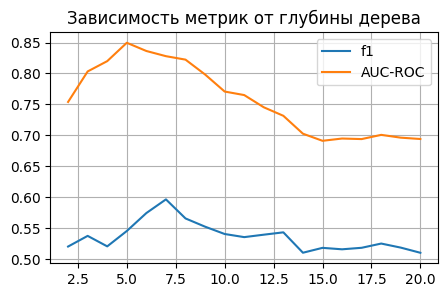

           2     3     4     5     6     7     8     9     10    11    12  \
f1       0.52  0.54  0.52  0.55  0.57  0.60  0.57  0.55  0.54  0.54  0.54   
AUC-ROC  0.75  0.80  0.82  0.85  0.84  0.83  0.82  0.80  0.77  0.77  0.75   

           13    14    15    16    17    18    19    20  
f1       0.54  0.51  0.52  0.52  0.52  0.53  0.52  0.51  
AUC-ROC  0.73  0.70  0.69  0.69  0.69  0.70  0.70  0.69   

f1(max)=0.597 при глубине 7   (AUC-ROC=0.828)


In [42]:
dtc_get_metrics(features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid)

#### RandomForestClassifier

In [43]:
def rfc_get_metrics(ft,fv,tt,tv,weight=None,criterion='gini'):
    '''возвращает 2 df со значениями f1 и AUC-ROC в зависимости от глубины и кол-ва деревьев для RandomForestClassifier'''
    f1_df = pd.DataFrame(index=range(4,21),columns=range(20,201,20)); auc_roc_df = f1_df.copy()
    for d in range(4,21):
        for e in range(20,201,20):
            f1,auc_roc,prob,pred = ml('RFC',ft,fv,tt,tv,depth=d,est=e,weight=weight,criterion=criterion)
            f1_df.loc[d,e] = f1; auc_roc_df.loc[d,e] = auc_roc
# почему-то без этого перевода типов датафрэймы не округлить и не построить тепловую диаграмму
    return f1_df.astype(float), auc_roc_df.astype(float) 

In [44]:
def rfc_heatmaps(f1_df, auc_roc_df):
    '''выводит 2 df со значениями f1 и AUC-ROC в зависимости от глубины и кол-ва деревьев для RandomForestClassifier; 
    также выводит f1(max) c соответствующими гиперпараметрами и соответствующим AUC-ROC'''
    plt.figure(figsize=(6,4.5))
    sns.heatmap(f1_df,annot=True, linewidth=1, fmt='.2f')
    plt.xlabel('n_estimators'); plt.ylabel('depth'); plt.title('f1 в зависимости от глубины и числа деревьев')
    
    plt.figure(figsize=(6,4.5))
    sns.heatmap(auc_roc_df,annot=True, linewidth=1, fmt='.2f')
    plt.xlabel('n_estimators'); plt.ylabel('depth'); plt.title('AUC-ROC в зависимости от глубины и числа деревьев'); plt.show()
    
    f1_max = pd.DataFrame([f1_df.idxmax()],['depth']).T.join(pd.DataFrame([f1_df.max()],['f1']).T).sort_values(by='f1',
                                                                                                  ascending=False)
    print(f"f1(max)={f1_max.iloc[0,1]:.3f} при глубине {f1_max.iloc[0,0]} и числе деревьев {f1_max.index[0]}\
          (AUC-ROC={auc_roc_df.loc[f1_max.iloc[0,0],f1_max.index[0]]:.3f})")

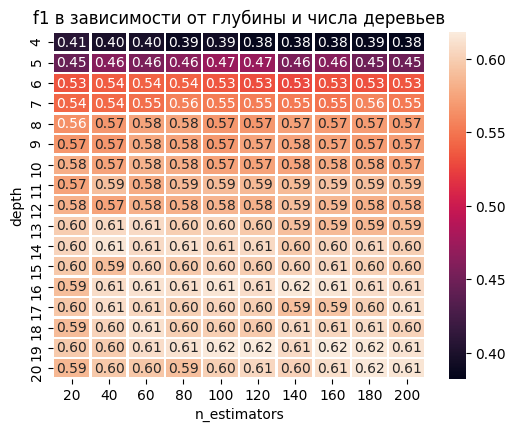

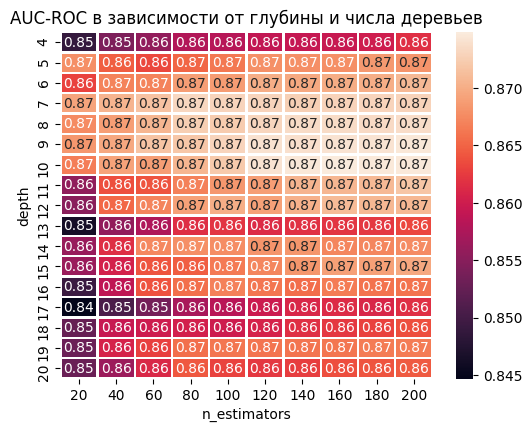

f1(max)=0.618 при глубине 19 и числе деревьев 120          (AUC-ROC=0.866)


In [45]:
# массивы со значениями f1 и AUC-ROC в зависимости от гиперпараметров
f1_df, auc_roc_df = rfc_get_metrics(features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid)
rfc_heatmaps(f1_df, auc_roc_df)

### Вывод

* Дисбаланс классов 1/4, что без балансировки может негативно отразится на качестве модели.
* Модели трёх типов, обученные без балансирования данных и с подбором гиперпараметров, дали на валидационной выборке результаты:\
Logistic Regression: f1 =0.311    AUC-ROC = 0.787\
DecisionTreeClassifier: f1(max)=0.597 при глубине 7   (AUC-ROC=0.828)\
RandomForestClassifier: f1(max)=0.618 при глубине 19 и числе деревьев 120 (AUC-ROC=0.866)

## Создание модели (выбор алгоритма и обучение)

### Борьба с дисбалансом

#### class_weight

##### LogisticRegression

Проверка качества на валидационной выборке c учётом балансировки. Экспериментируем с разным solver.

In [46]:
f1,auc_roc,prob,pred = ml('LR',features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid,
                     weight='balanced')
print(f'f1 ={f1:.3f}    AUC-ROC = {auc_roc:.3f}')

f1 =0.528    AUC-ROC = 0.794


In [47]:
f1,auc_roc,prob,pred = ml('LR',features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid,
                     weight='balanced',solver='liblinear')
print(f'f1 ={f1:.3f}    AUC-ROC = {auc_roc:.3f}')

f1 =0.528    AUC-ROC = 0.794


In [48]:
f1,auc_roc,prob,pred = ml('LR',features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid,
                     weight='balanced',solver='newton-cg')
print(f'f1 ={f1:.3f}    AUC-ROC = {auc_roc:.3f}')

f1 =0.528    AUC-ROC = 0.794


In [49]:
f1,auc_roc,prob,pred = ml('LR',features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid,
                     weight='balanced',solver='newton-cholesky')
print(f'f1 ={f1:.3f}    AUC-ROC = {auc_roc:.3f}')

f1 =0.528    AUC-ROC = 0.794


##### DecisionTreeClassifier

Проверка качества на валидационной выборке c подбором глубины и c учётом балансировки. Экспериментируем с разными критериями.

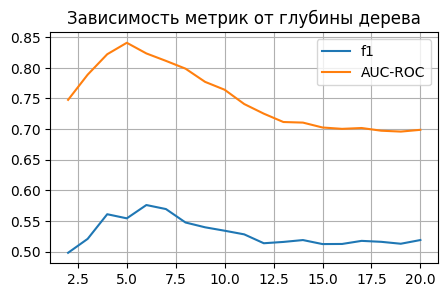

           2     3     4     5     6     7     8     9     10    11    12  \
f1       0.50  0.52  0.56  0.55  0.58  0.57  0.55  0.54  0.53  0.53  0.51   
AUC-ROC  0.75  0.79  0.82  0.84  0.82  0.81  0.80  0.78  0.76  0.74  0.73   

           13    14    15    16    17    18    19    20  
f1       0.52  0.52  0.51  0.51  0.52  0.52  0.51  0.52  
AUC-ROC  0.71  0.71  0.70  0.70  0.70  0.70  0.70  0.70   

f1(max)=0.576 при глубине 6   (AUC-ROC=0.823)


In [50]:
dtc_get_metrics(features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid,weight='balanced')

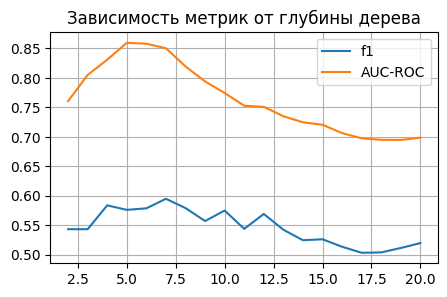

           2     3     4     5     6     7     8     9     10    11    12  \
f1       0.54  0.54  0.58  0.58  0.58  0.59  0.58  0.56  0.57  0.54  0.57   
AUC-ROC  0.76  0.81  0.83  0.86  0.86  0.85  0.82  0.79  0.77  0.75  0.75   

           13    14    15    16   17    18    19    20  
f1       0.54  0.52  0.53  0.51  0.5  0.50  0.51  0.52  
AUC-ROC  0.73  0.72  0.72  0.71  0.7  0.69  0.69  0.70   

f1(max)=0.595 при глубине 7   (AUC-ROC=0.850)


In [51]:
dtc_get_metrics(features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid,weight='balanced',
                criterion='entropy')

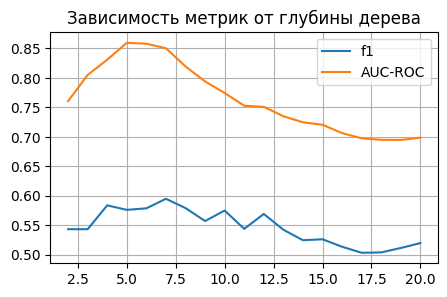

           2     3     4     5     6     7     8     9     10    11    12  \
f1       0.54  0.54  0.58  0.58  0.58  0.59  0.58  0.56  0.57  0.54  0.57   
AUC-ROC  0.76  0.81  0.83  0.86  0.86  0.85  0.82  0.79  0.77  0.75  0.75   

           13    14    15    16   17    18    19    20  
f1       0.54  0.52  0.53  0.51  0.5  0.50  0.51  0.52  
AUC-ROC  0.73  0.72  0.72  0.71  0.7  0.69  0.69  0.70   

f1(max)=0.595 при глубине 7   (AUC-ROC=0.850)


In [52]:
dtc_get_metrics(features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid,weight='balanced',
                criterion='log_loss')

##### RandomForestClassifier

Массивы со значениями f1 и AUC-ROC в зависимости от гиперпараметров и с учётом балансировки. Экспериментируем с разными критериями.

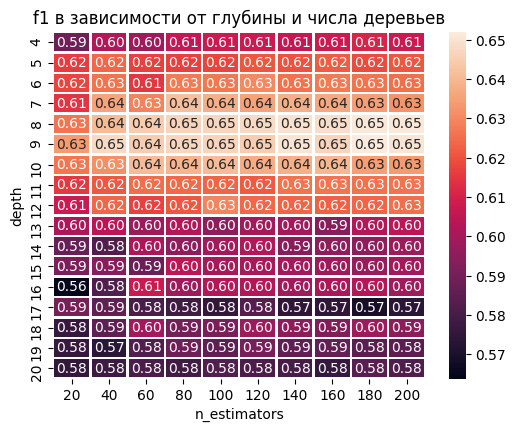

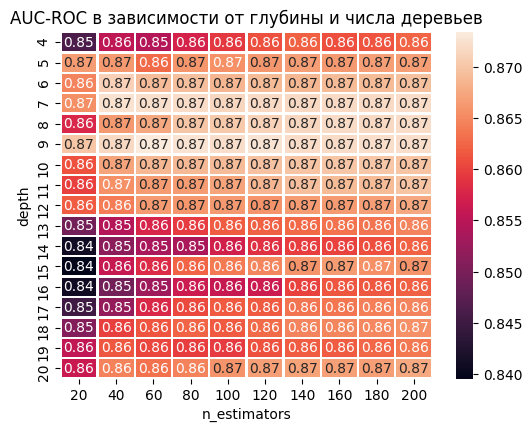

f1(max)=0.652 при глубине 9 и числе деревьев 180          (AUC-ROC=0.872)


In [53]:
f1_df, auc_roc_df = rfc_get_metrics(features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid,
                                    weight='balanced')
rfc_heatmaps(f1_df, auc_roc_df)

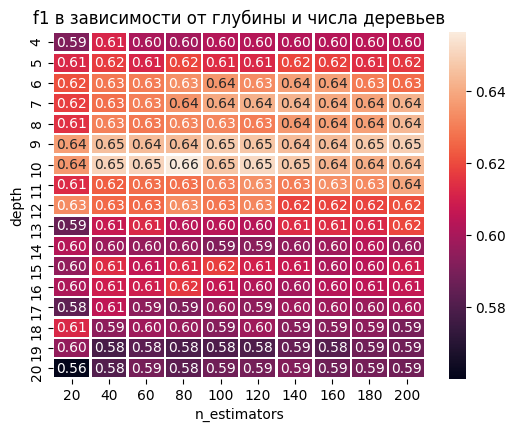

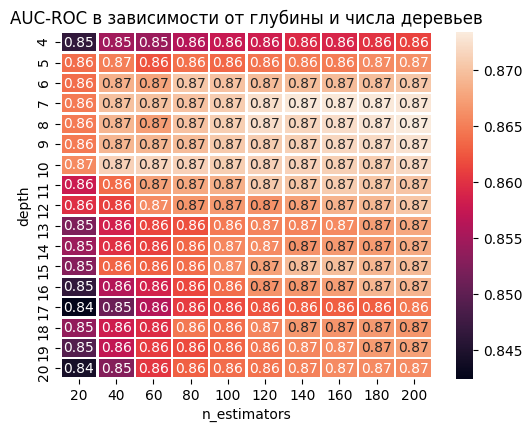

f1(max)=0.656 при глубине 10 и числе деревьев 80          (AUC-ROC=0.871)


In [54]:
f1_df, auc_roc_df = rfc_get_metrics(features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid,
                                    weight='balanced',criterion='entropy')
rfc_heatmaps(f1_df, auc_roc_df)

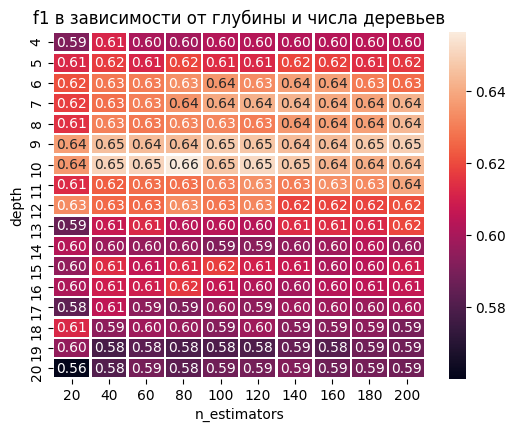

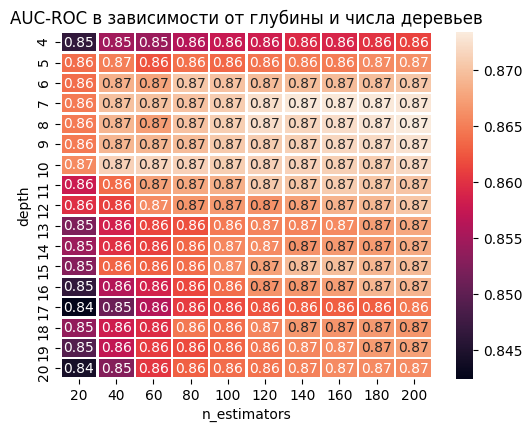

f1(max)=0.656 при глубине 10 и числе деревьев 80          (AUC-ROC=0.871)


In [55]:
f1_df, auc_roc_df = rfc_get_metrics(features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid,
                                    weight='balanced',criterion='log_loss')
rfc_heatmaps(f1_df, auc_roc_df)

#### upsampling

In [56]:
# увеличиваем количество объектов "1" в обучающей выборке в ~4 раза (т.к. дисбаланс 1/4)
oversample = SMOTE(random_state=12345)
features_train_upsampled, target_train_upsampled = oversample.fit_resample(features_ohe_train_scaled, target_ohe_train)

##### LogisticRegression

In [57]:
# проверка качества на валидационной выборке и c учётом upsampling
f1,auc_roc,prob,pred = ml('LR',features_train_upsampled,features_ohe_valid_scaled,target_train_upsampled,target_ohe_valid)
print(f'f1 ={f1:.3f}    AUC-ROC = {auc_roc:.3f}')

f1 =0.528    AUC-ROC = 0.791


##### DecisionTreeClassifier

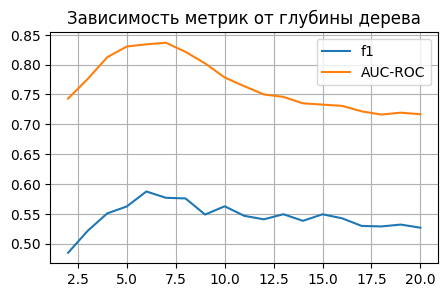

           2     3     4     5     6     7     8     9     10    11    12  \
f1       0.48  0.52  0.55  0.56  0.59  0.58  0.58  0.55  0.56  0.55  0.54   
AUC-ROC  0.74  0.78  0.81  0.83  0.83  0.84  0.82  0.80  0.78  0.76  0.75   

           13    14    15    16    17    18    19    20  
f1       0.55  0.54  0.55  0.54  0.53  0.53  0.53  0.53  
AUC-ROC  0.75  0.74  0.73  0.73  0.72  0.72  0.72  0.72   

f1(max)=0.587 при глубине 6   (AUC-ROC=0.834)


In [58]:
# проверка качества на валидационной выборке c подбором глубины и c учётом upsampling
dtc_get_metrics(features_train_upsampled,features_ohe_valid_scaled,target_train_upsampled,target_ohe_valid)

##### RandomForestClassifier

Массивы со значениями f1 и AUC-ROC в зависимости от гиперпараметров и с учётом upsampling. Экспериментируем с разными критериями.

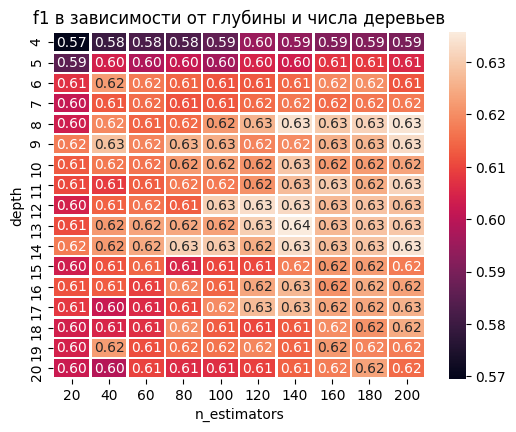

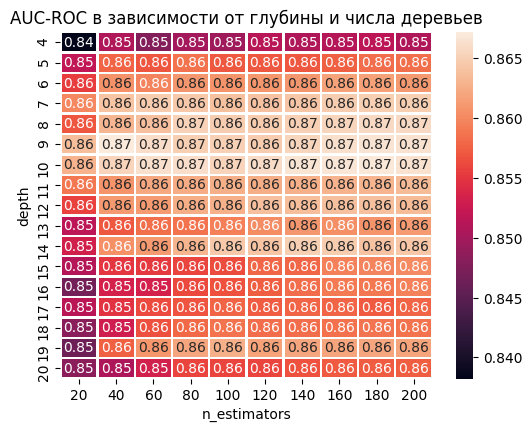

f1(max)=0.636 при глубине 13 и числе деревьев 140          (AUC-ROC=0.861)


In [59]:
f1_df, auc_roc_df = rfc_get_metrics(features_train_upsampled,features_ohe_valid_scaled,target_train_upsampled,target_ohe_valid)
rfc_heatmaps(f1_df, auc_roc_df)

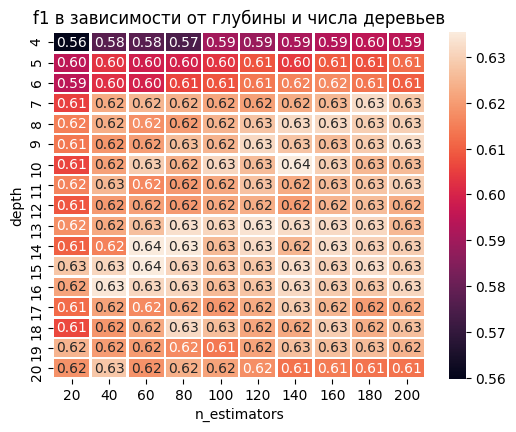

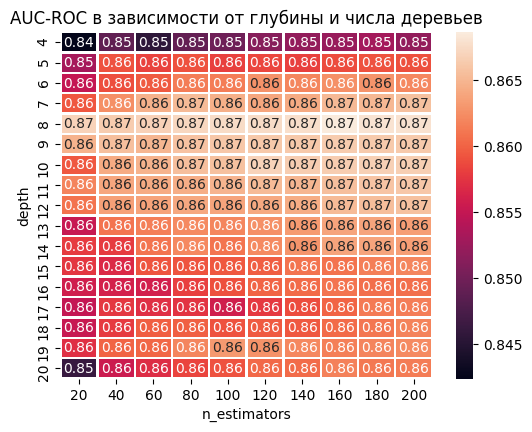

f1(max)=0.635 при глубине 10 и числе деревьев 140          (AUC-ROC=0.867)


In [60]:
f1_df, auc_roc_df = rfc_get_metrics(features_train_upsampled,features_ohe_valid_scaled,target_train_upsampled,target_ohe_valid,
                                    criterion='entropy')
rfc_heatmaps(f1_df, auc_roc_df)

#### downsampling

In [61]:
# уменьшаем количество объектов "0" в обучающей выборке в ~4 раза (т.к. дисбаланс 1/4)
oversample = RandomUnderSampler(random_state=12345)
features_train_downsampled, target_train_downsampled = oversample.fit_resample(features_ohe_train_scaled, target_ohe_train)

##### LogisticRegression

In [62]:
# проверка качества на валидационной выборке и c учётом downsampling
f1,auc_roc,prob,pred = ml('LR',features_train_downsampled,features_ohe_valid_scaled,target_train_downsampled,target_ohe_valid)
print(f'f1 ={f1:.3f}    AUC-ROC = {auc_roc:.3f}')

f1 =0.527    AUC-ROC = 0.792


##### DecisionTreeClassifier

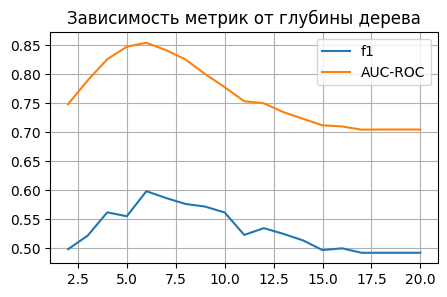

           2     3     4     5     6     7     8     9     10    11    12  \
f1       0.50  0.52  0.56  0.55  0.60  0.59  0.58  0.57  0.56  0.52  0.53   
AUC-ROC  0.75  0.79  0.82  0.85  0.85  0.84  0.82  0.80  0.78  0.75  0.75   

           13    14    15    16    17    18    19    20  
f1       0.52  0.51  0.50  0.50  0.49  0.49  0.49  0.49  
AUC-ROC  0.73  0.72  0.71  0.71  0.70  0.70  0.70  0.70   

f1(max)=0.598 при глубине 6   (AUC-ROC=0.853)


In [63]:
# проверка качества на валидационной выборке c подбором глубины и c учётом downsampling
dtc_get_metrics(features_train_downsampled,features_ohe_valid_scaled,target_train_downsampled,target_ohe_valid)

##### RandomForestClassifier

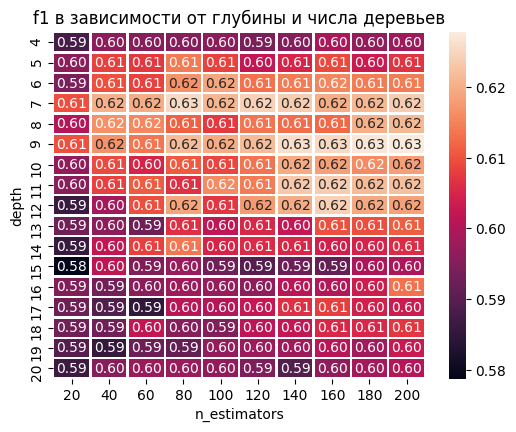

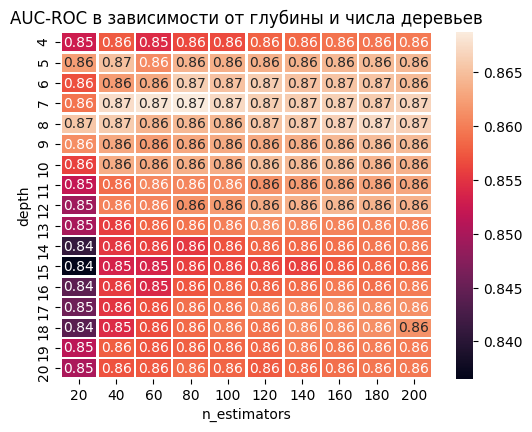

f1(max)=0.628 при глубине 9 и числе деревьев 200          (AUC-ROC=0.865)


In [64]:
# массивы со значениями f1 и AUC-ROC в зависимости от гиперпараметров и с учётом downsampling
f1_df, auc_roc_df = rfc_get_metrics(features_train_downsampled,features_ohe_valid_scaled,
                                    target_train_downsampled,target_ohe_valid)
rfc_heatmaps(f1_df, auc_roc_df)

#### порог классификации

##### LogisticRegression

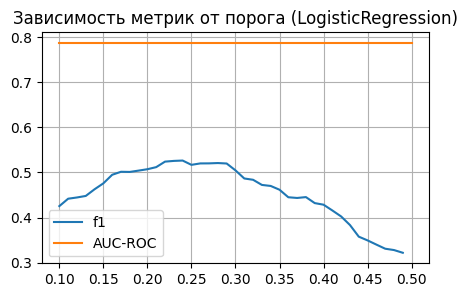

AUC-ROC = 0.787          f1(max) = 0.526 при threshold = 0.240


In [65]:
# проверка качества на разных порогах
model = LogisticRegression(random_state=12345, solver='lbfgs')
model.fit(features_ohe_train_scaled,target_ohe_train)
probabilities_ohe_valid = model.predict_proba(features_ohe_valid_scaled)
threshold,f1=[],[]
for t in np.arange(0.1,0.5,0.01):
    predicted_ohe_valid = probabilities_ohe_valid[:,1]>t
    f1.append(f1_score(target_ohe_valid,predicted_ohe_valid))
    threshold.append(t)
AUC_ROC = roc_auc_score(target_ohe_valid,probabilities_ohe_valid[:,1])
pd.Series(f1,threshold).plot(title = 'Зависимость метрик от порога (LogisticRegression)',figsize=(5,3),legend=True, label='f1')
pd.Series(data=AUC_ROC,index=[0.1,0.5]).plot(grid=True,legend=True,label='AUC-ROC')
plt.show()
print (f'AUC-ROC = {AUC_ROC:.3f} \
         f1(max) = {pd.Series(f1,threshold).max():.3f} при threshold = {pd.Series(f1,threshold).idxmax():.3f}')

##### RandomForestClassifier

In [66]:
# проверка качества на разных порогах,глубинах и кол-ве деревьев; формируем df с общими данными
threshold_df = pd.DataFrame(columns=['threshold','depth','est','f1','AUC-ROC'])
for d in range(7,14):
        for e in range(60,181,20):
            model = RandomForestClassifier(random_state=12345, n_estimators=e, max_depth=d)
            model.fit(features_ohe_train_scaled,target_ohe_train)
            probabilities_ohe_valid = model.predict_proba(features_ohe_valid_scaled)
            auc_roc = roc_auc_score(target_ohe_valid,probabilities_ohe_valid[:,1])
            for t in np.arange(0.3,0.36,0.01):
                predicted_ohe_valid = probabilities_ohe_valid[:,1]>t
                f1 = f1_score(target_ohe_valid,predicted_ohe_valid)
                threshold_df = pd.concat([threshold_df,pd.DataFrame(data=[[t,d,e,f1,auc_roc]],
                                                                    columns=['threshold','depth','est','f1','AUC-ROC'])])

In [67]:
# максимальные значения f1 c соответствующими гиперпараметрами и AUC-ROC
threshold_df.sort_values(by='f1',ascending=False).head(3)

threshold depth  est        f1   AUC-ROC
0       0.33     9  140  0.661616  0.873998
0       0.35    11  100  0.661538  0.868400
0       0.33     9  120  0.659873  0.874076

##### RandomForestClassifier (entropy)

In [68]:
# проверка качества на разных порогах,глубинах и кол-ве деревьев; формируем df с общими данными
threshold_df = pd.DataFrame(columns=['threshold','depth','est','f1','AUC-ROC'])
for d in range(7,14):
        for e in range(60,181,20):
            model = RandomForestClassifier(random_state=12345, n_estimators=e, max_depth=d,criterion='entropy')
            model.fit(features_ohe_train_scaled,target_ohe_train)
            probabilities_ohe_valid = model.predict_proba(features_ohe_valid_scaled)
            auc_roc = roc_auc_score(target_ohe_valid,probabilities_ohe_valid[:,1])
            for t in np.arange(0.3,0.36,0.01):
                predicted_ohe_valid = probabilities_ohe_valid[:,1]>t
                f1 = f1_score(target_ohe_valid,predicted_ohe_valid)
                threshold_df = pd.concat([threshold_df,pd.DataFrame(data=[[t,d,e,f1,auc_roc]],
                                                                    columns=['threshold','depth','est','f1','AUC-ROC'])])

In [69]:
# максимальные значения f1 c соответствующими гиперпараметрами и AUC-ROC
threshold_df.sort_values(by='f1',ascending=False).head(3)

threshold depth  est        f1   AUC-ROC
0       0.34     9  100  0.655570  0.872985
0       0.30    10  160  0.654028  0.872866
0       0.32     8  160  0.653317  0.873739

#### Вывод:

Отрицательное влияние дисбаланса нивелировалось разными методами с достижением результатов:
* class_weight <br> 
(LR) f1 =0.528, AUC-ROC = 0.794\
(DTC) f1(max)=0.595 при глубине 7,   (AUC-ROC=0.850)\
(RFC) f1(max)=0.656 при глубине 10 и числе деревьев 80,      (AUC-ROC=0.871)
* upsampling <br>
(LR) f1 =0.527,    AUC-ROC = 0.791\
(DTC) f1(max)=0.587 при глубине 6,   (AUC-ROC=0.834)\
(RFC) f1(max)=0.636 при глубине 13 и числе деревьев 140,          (AUC-ROC=0.861)
* downsampling <br>
(LR) f1 =0.527,    AUC-ROC = 0.792\
(DTC) f1(max)=0.598 при глубине 6   (AUC-ROC=0.853)\
(RFC) f1(max)=0.628 при глубине 9 и числе деревьев 200,          (AUC-ROC=0.865)
* порог классификации<br>
(LR) f1(max) = 0.526 при threshold = 0.240, (AUC-ROC = 0.787)\
* **(RFC) f1(max) = 0.662 при threshold = 0.33, глубине 9, числе деревьев 140 (AUC-ROC = 0.874)** \
\
Лучший результат метрик с алгоритмом RandomForestClassifier при использовании порога классификации.

### Проверка на вменяемость

In [70]:
# константная модель (1)
dummy_clf = DummyClassifier(strategy="constant",constant=1)
dummy_clf.fit(features_ohe_train_scaled, target_ohe_train)
predicted_dummy = dummy_clf.predict(features_ohe_valid_scaled)
prob = dummy_clf.predict_proba(features_ohe_valid_scaled)

print(f'f1={f1_score(target_ohe_valid,predicted_dummy):.3f}, recall={recall_score(target_ohe_valid,predicted_dummy):.3f},\
 precision={precision_score(target_ohe_valid,predicted_dummy):.3f}, AUC-ROC={roc_auc_score(target_ohe_valid,prob[:,1]):.3f}')

f1=0.339, recall=1.000, precision=0.204, AUC-ROC=0.500


In [71]:
# ровномерная модель (50/50)
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(features_ohe_train_scaled, target_ohe_train)
predicted_dummy = dummy_clf.predict(features_ohe_valid_scaled)
prob = dummy_clf.predict_proba(features_ohe_valid_scaled)

print(f'f1={f1_score(target_ohe_valid,predicted_dummy):.3f}, recall={recall_score(target_ohe_valid,predicted_dummy):.3f},\
 precision={precision_score(target_ohe_valid,predicted_dummy):.3f}, AUC-ROC={roc_auc_score(target_ohe_valid,prob[:,1]):.3f}')

f1=0.289, recall=0.510, precision=0.202, AUC-ROC=0.500


Все 3 модели (LR, DTC, RFC) показали более высокий результат метрик относительно константой и ровномерной.

### Графики метрик для выбранной модели

In [72]:
f1_05,auc_roc,prob,pred_05 = ml('RFC',features_ohe_train_scaled,features_ohe_valid_scaled,target_ohe_train,target_ohe_valid,
                     depth=9,est=140)
# метрики для порога 0.33
pred_033 = prob[:,1]>0.33
recall_033 = recall_score(target_ohe_valid,pred_033)
precision_033 = precision_score(target_ohe_valid,pred_033)
f1_033 = f1_score(target_ohe_valid,pred_033)
# метрики для порога 0.5
recall_05 = recall_score(target_ohe_valid,pred_05)
precision_05 = precision_score(target_ohe_valid,pred_05)

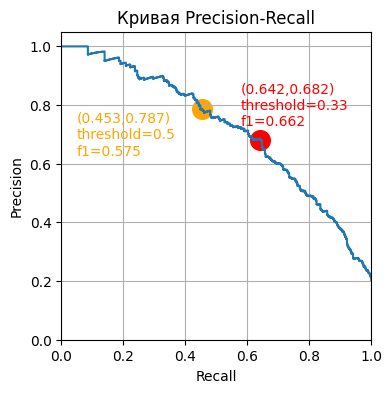

In [73]:
precision, recall, thresholds = precision_recall_curve(target_ohe_valid,prob[:,1])
plt.figure(figsize=(4,4)); plt.step(recall, precision, where='post')

plt.scatter(x=recall_05,y=precision_05,marker='o',color='orange',s=200)
plt.text(0.05, 0.63, f'({recall_05:.3f},{precision_05:.3f})\nthreshold=0.5\nf1={f1_05:.3f}',color='orange')
plt.scatter(x=recall_033,y=precision_033,marker='o',color='red',s=200)
plt.text(0.58, 0.73, f'({recall_033:.3f},{precision_033:.3f})\nthreshold=0.33\nf1={f1_033:.3f}',color='red')

plt.xlabel('Recall'); plt.ylabel('Precision') 
plt.ylim([0.0, 1.05]); plt.xlim([0.0, 1.0]); plt.title('Кривая Precision-Recall'); plt.grid(True); plt.show() 

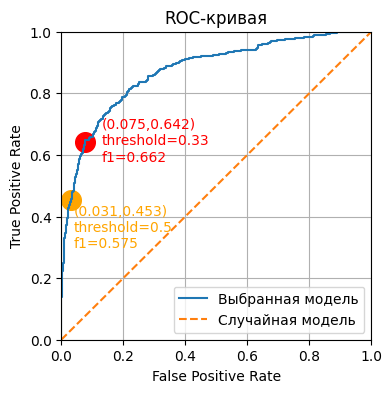

In [74]:
fpr, tpr, thresholds = roc_curve(target_ohe_valid,prob[:,1])

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr); plt.plot([0, 1], [0, 1], linestyle='--') 
plt.ylim([0.0, 1.0]); plt.xlim([0.0, 1.0])

# FPR для двух соответствующих значений TPR
fpr_033 = (pd.DataFrame({'fpr':fpr,'tpr':tpr,'thresholds':thresholds}).set_index('thresholds').
           query('tpr.round(3)==@recall_033.round(3)').iloc[0,0])
fpr_05 = (pd.DataFrame({'fpr':fpr,'tpr':tpr,'thresholds':thresholds}).set_index('thresholds').
           query('tpr.round(3)==@recall_05.round(3)').iloc[0,0])

plt.scatter(x=fpr_05,y=recall_05,marker='o',color='orange',s=200)
plt.text(0.04, 0.3, f'({fpr_05:.3f},{recall_05:.3f})\nthreshold=0.5\nf1={f1_05:.3f}',color='orange')
plt.scatter(x=fpr_033,y=recall_033,marker='o',color='red',s=200)
plt.text(0.13, 0.58, f'({fpr_033:.3f},{recall_033:.3f})\nthreshold=0.33\nf1={f1_033:.3f}',color='red')

plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC-кривая'); plt.grid(True); 
plt.legend(['Выбранная модель', 'Случайная модель']); plt.show()

### Вывод

В продакшен выдаём модель RandomForestClassifier с гиперпараметрами: depth=9, n_estimators=140, random_state=12345 с учётом порога классификации 0.33.\
На валидационной выборке f1 = 0.662, TPR = 0.642, FPR = 0.075, AUC-ROC = 0.874.

## Тестирование модели

### Проверка на тестовой выборке

In [75]:
f1_05,auc_roc,prob,pred = ml('RFC',features_ohe_train_scaled,features_ohe_test_scaled,target_ohe_train,target_ohe_test,
                     depth=9,est=140)
predicted_ohe_test = prob[:,1]>0.33
print(f'f1={f1_score(target_ohe_test,predicted_ohe_test):.3f}, AUC-ROC={auc_roc:.3f}')

f1=0.593, AUC-ROC=0.855


## Вывод итоговый

* Создана модель с метриками качества на валидационной выборке: f1 = 0.662, TPR = 0.642, FPR = 0.075, AUC-ROC = 0.874.<br> 
Таким образом модель верно детектирует 64.2% клиентов на отток.
* Модель прошла проверку на вменяемось. Сравнивалась с константной (f1=0.339) и случайной (f1=0.301).
* Проведена проверка на тестовой выборке: f1=0.593, AUC-ROC=0.855.
* Модель построена на базе алгоритма RandomForestClassifier с гиперпараметрами: depth=9, n_estimators=140, random_state=12345 с учётом порога классификации 0.33.<br>

**Дополнительно:**<br>
* исходный датафрейм 10000 х 14; в признаке "Tenure" 909 пропусков (9%), причина неясна, связь наличия пропусков с другими признаками отсутствует; для ML пропуски заполнены медианным значением с учётом классовой стратификации; дубликатов нет;
* возраст покинувших банк на 20% выше; слабая положительная связь "Exited" и "Age";
* баланс покинувших банк на 20-30% выше; разница получается за счёт большого количества нулевых счетов у оставшихся клиентов; если убрать нулевые значения средние балансов будут примерно равны у оставшихся и ушедших; нулевых балансов нет у клиентов в Германии;
* покинувшие банк использовали меньшее число продуктов и были менее активны; в то же время пользование 3-мя или 4-мя продуктами в небольших количествах было, в основном, у покинувших;
* слабая отрицательная связь между NumOfProducts и Balance; более состоятельные клиенты предпочитают не распыляться по разным продуктам и делают ставку на небольшое количество видов услуг;
* среди покинувших банк больше женщин (60%); среди оставшихся больше мужчин (60%); общее количество мужчин (55%);
* кредитный рейтинг, срок пользования банком, наличие кредитной карты и зарплата не влияют на решение оставить банк;
* Экстремумы метрик f1 и AUC-ROC не совпадают на одних гиперпараметрах (хотя и несильно расходятся).

